# Conv-LSTM Encoder-Decoder Model

In [31]:
import seaborn as sns

import pandas as pd
from pandas import read_csv

import numpy as np
from numpy import split
from numpy import array

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import LSTM
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
from keras.utils.vis_utils import plot_model

from math import sqrt
from datetime import datetime
from matplotlib import pyplot


Helper functions used in this process.

In [32]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard 6 hour intervals
    train = data[0:-677]
    test = data[-677:-23]
    # Restructure data into windows of 6 hours
    train = array(split(train, len(train)/6), dtype=object)
    test = array(split(test, len(test)/6), dtype=object)
    return train, test


We will use the first three months of data for training predictive models and the final month for evaluating models.

In [33]:
# evaluate one or more 6 hour forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # Calculate an RMSE score for each hour
    for i in range(actual.shape[1]):
        # calculate MSE
        mse = mean_squared_error([reverse_minmaxscaler(x) for x in actual[:, i]], [
                                 reverse_minmaxscaler(x) for x in predicted[:, i]])
        # calculate RMSE
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (reverse_minmaxscaler(actual[row, col]) -
                  reverse_minmaxscaler(predicted[row, col]))**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores

# summarize scores


def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.6f] %s' % (name, score, s_scores))

# convert history into inputs and output


def to_supervised(train, n_input, n_out=6):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, [0, 10, 11, 12]]
            X.append(x_input)
            # X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)

# train the model
def build_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
    train_x = np.asarray(train_x).astype(np.float32)
    train_y = np.asarray(train_y).astype(np.float32)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    plot_model(model, to_file='plot_conv_lstm.png', show_shapes=True, show_layer_names=True)
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model


# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, [0, 10, 11, 12]]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, input_x.shape[1]))
    # https://stackoverflow.com/questions/58636087/tensorflow-valueerror-failed-to-convert-a-numpy-array-to-a-tensor-unsupporte
    input_x = np.asarray(input_x).astype(np.float32)
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat

# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
	# fit model
	model = build_model(train, n_steps, n_length, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions)
	return score, scores, predictions


In [34]:
# load the new file
dataset = read_csv('./processed_datasets/dogecoin_price_sentiments_hours.csv', header=0,
                   infer_datetime_format=True, parse_dates=['timestamp'], index_col=['timestamp']).dropna()

max_val = max(dataset['dogecoin_price'])
min_val = min(dataset['dogecoin_price'])

scaler = MinMaxScaler()
scaled_data = pd.DataFrame(scaler.fit_transform(
    dataset), columns=dataset.columns, index=dataset.index)


def reverse_minmaxscaler(scaled_val):
    og_val = (scaled_val*(max_val - min_val)) + min_val
    return og_val


# split into train and test
train, test = split_dataset(scaled_data.values)

# define the number of subsequences and the length of subsequences
# n_steps, n_length = 2, 7
# define the total days to use as input
# n_input = n_length * n_steps
# score, scores = evaluate_model(train, test, n_steps, n_length, n_input)


score_n = {}
scores_n = {}
predictions_n = {}

for n_steps in range(1, 4):
    n_length = 6
    print('n_steps: ', n_steps)
    print('n_length: ', n_length)
    n_input = n_length * n_steps
    print('n_input: ', n_input)
    score, scores, predictions = evaluate_model(train, test, n_steps, n_length, n_input)
    score_n[n_input] = np.asarray(score)
    scores_n[n_input] = np.asarray(scores)
    predictions_n[n_input] = np.asarray(predictions)


n_steps:  1
n_length:  6
n_input:  6
n_steps:  2
n_length:  6
n_input:  12
n_steps:  3
n_length:  6
n_input:  18


Summarize the scores

In [35]:
summarize_scores('lstm', score_n[6], scores_n[6])


lstm: [0.049389] 0.1, 0.1, 0.0, 0.0, 0.0, 0.0


Plot the scores

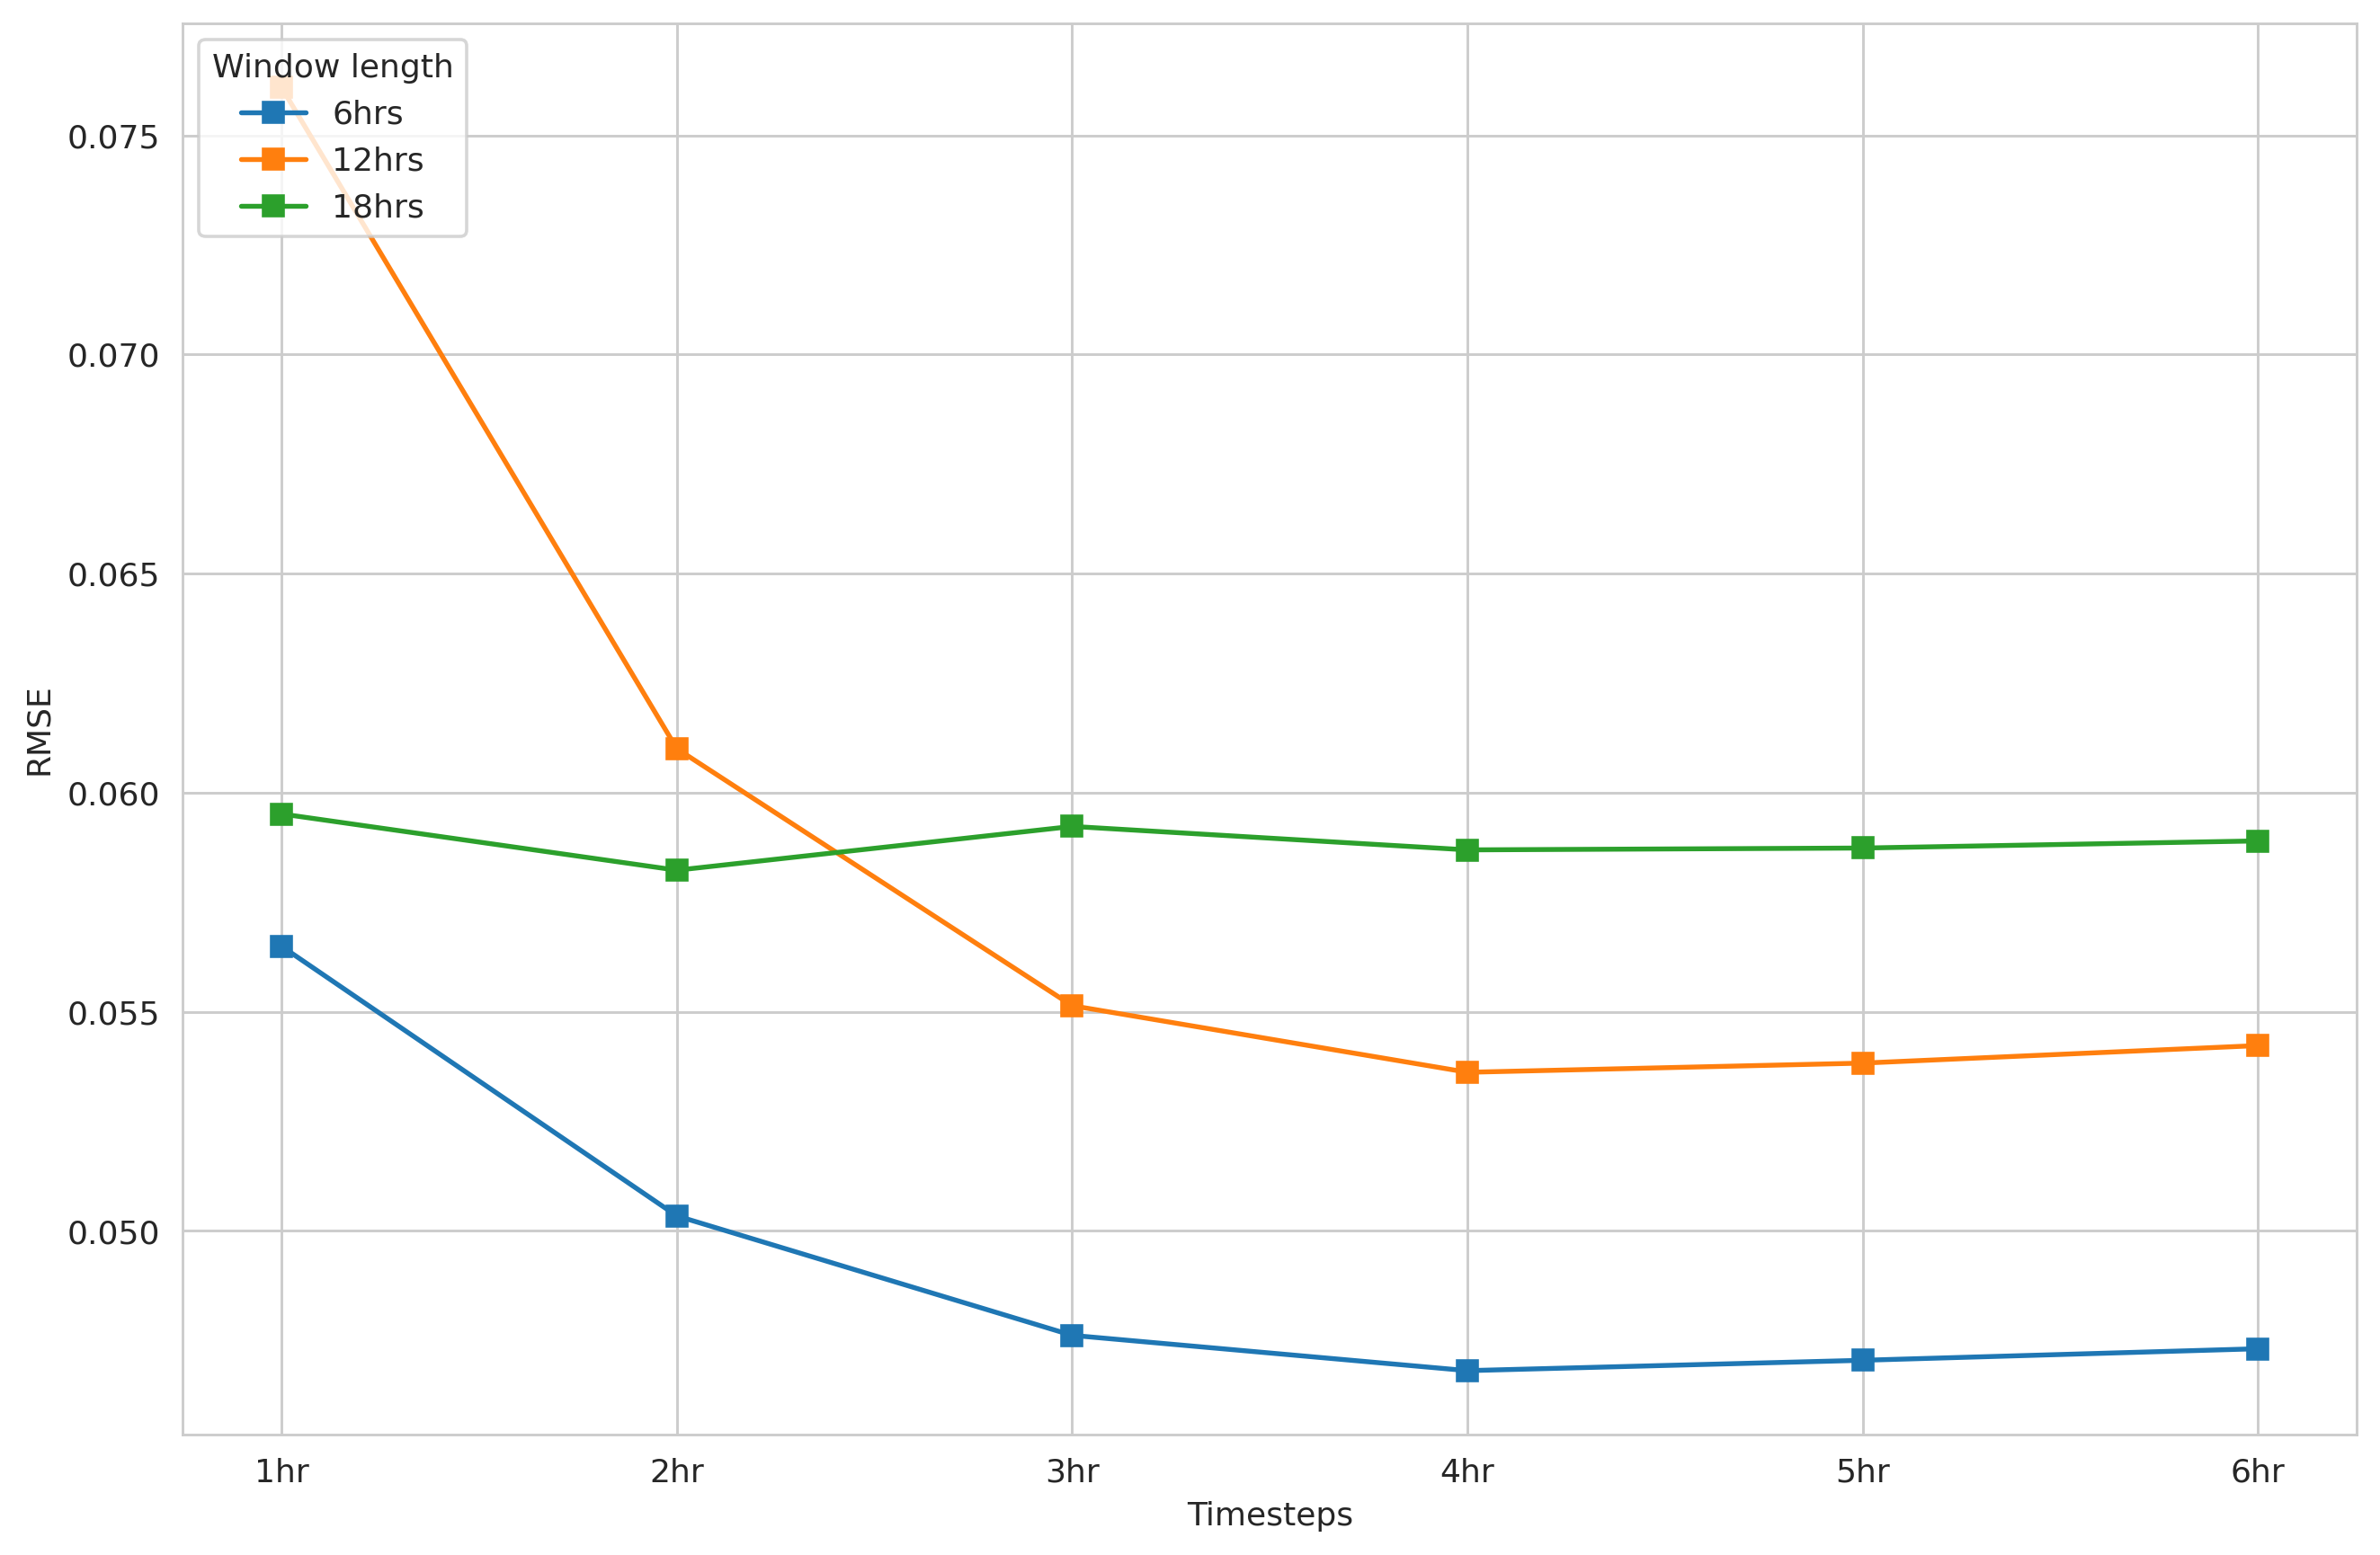

In [36]:
sns.set_style("whitegrid")
pyplot.figure(figsize=(12, 8), dpi=260)

# plot scores
days = ['1hr', '2hr', '3hr', '4hr', '5hr', '6hr']
pyplot.plot(days, scores_n[6], marker='s', label='6hrs')
pyplot.plot(days, scores_n[12], marker='s', label='12hrs')
pyplot.plot(days, scores_n[18], marker='s', label='18hrs')
pyplot.legend(loc="upper left", title="Window length")
pyplot.xlabel('Timesteps')
pyplot.ylabel('RMSE')

pyplot.show()


Plot the predictions

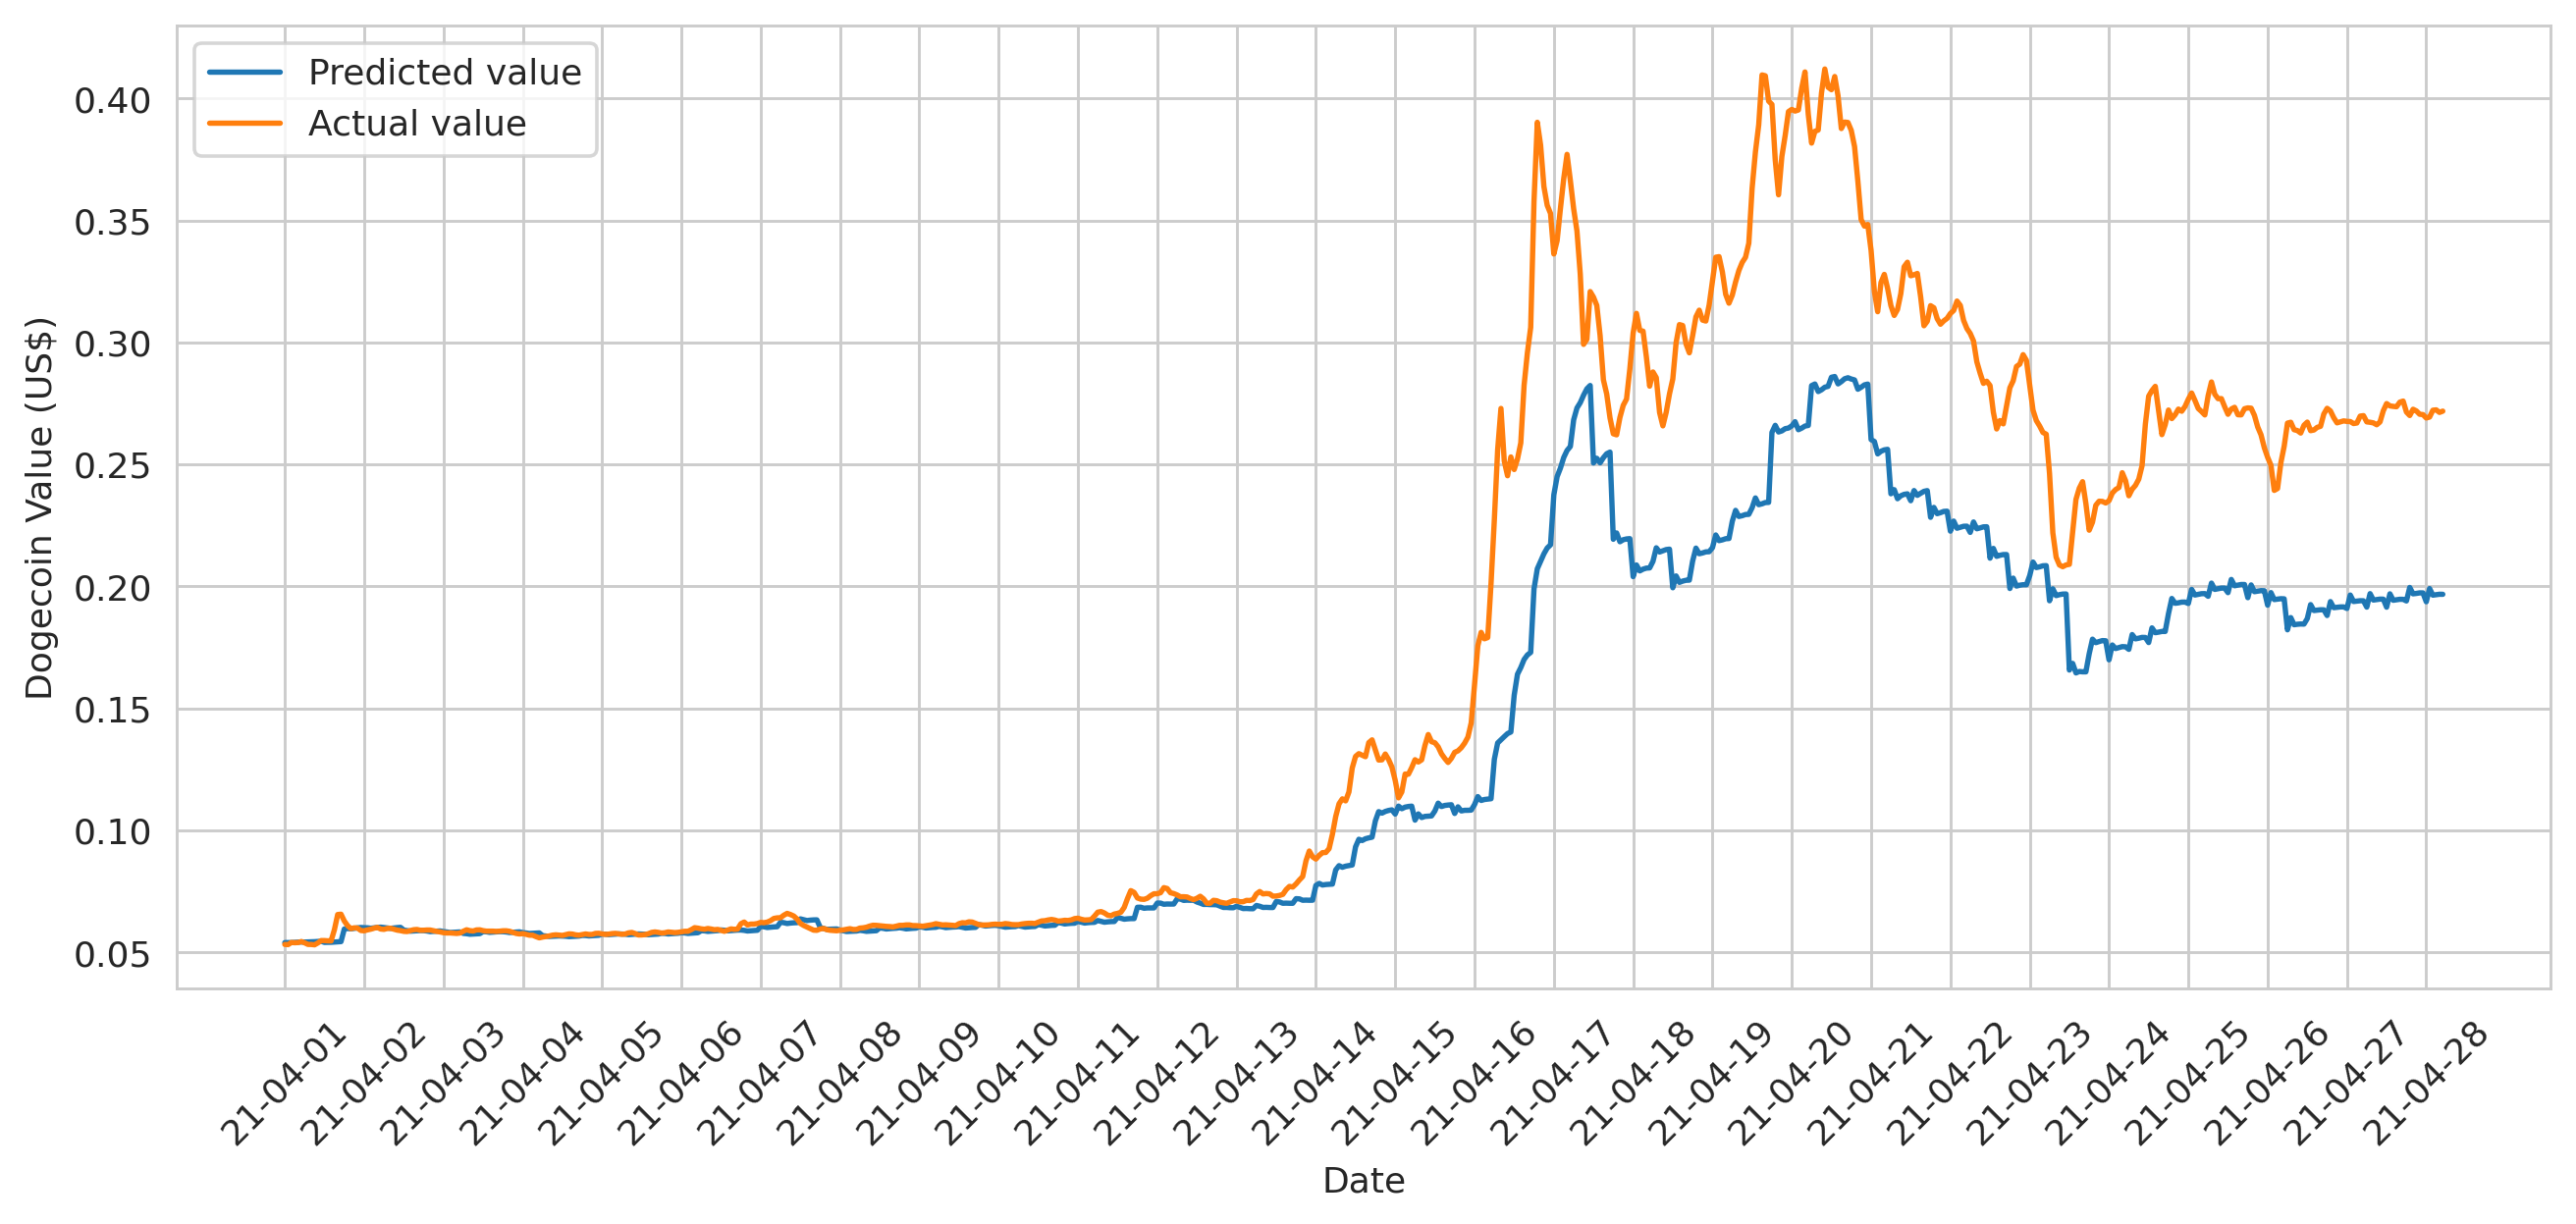

In [37]:
# take the 2nd hour predictions
prd_6 = predictions_n[6].flatten()
prd_12 = predictions_n[12].flatten()
prd_18 = predictions_n[18].flatten()
tst = test[:, :, 0].flatten()

prd_rev = [reverse_minmaxscaler(x) for x in prd_18]
tst_rev = [reverse_minmaxscaler(x) for x in tst]

sns.set_style("whitegrid")

pyplot.figure(figsize=(12, 5), dpi=260)
pyplot.plot(prd_rev, label='Predicted value')
pyplot.plot(tst_rev, label='Actual value')
pyplot.xticks(range(0, 654, 24), [
    datetime.fromtimestamp(1617235200+(ts*3600)).strftime('%y-%m-%d') for ts in range(0, 654, 24)
], rotation='45')
pyplot.xlabel('Date')
pyplot.ylabel('Dogecoin Value (US$)')
pyplot.legend(loc="upper left")
pyplot.show()


More evaluations

In [38]:

rmse = sqrt(mean_squared_error(tst, prd_6))
print('Test RMSE: %.6f' % rmse)

mae = mean_absolute_error(tst, prd_6)
print('Test MAE: %.6f' % mae)

mape = mean_absolute_percentage_error(tst, prd_6)
print('Test MAPE: %.6f' % mape)


Test RMSE: 0.121252
Test MAE: 0.080649
Test MAPE: 0.126824
